In [1]:
# imports
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [2]:
def convert_owid_data(this_data):
    """ Takes the OWID json as an input and returns a converted json as an output.
        Removes all isos starting with 'OWID_'. Some are removed as they are just aggregates of the
        country data.  Some are converted as they are actually countries whose existence is
        challenged by other countries (e.g. Kosovo)  OWID_WRL is convered to WRL, a synthetic
        'country' as it contains the aggregated data for the world that is used by other functions.
    """

    # the list(s) of OWID_ data that we are going to remove for consistency
    owid_list = ['OWID_AFR', 'OWID_ASI', 'OWID_EUR', 'OWID_EUN', 'OWID_HIC', 'OWID_LIC', 'OWID_LMC', 'OWID_NAM', 'OWID_OCE', 'OWID_SAM', 'OWID_UMC']
    
    # clear out the unneeded 'OWID_' entries
    [this_data.pop(i) for i in owid_list]

    # change the iso_code for Northern Cyprus, for consistency
    this_data['CYN'] = this_data.pop('OWID_CYN')

    # change the iso_code for Kosovo, for consistency
    this_data['KOS'] = this_data.pop('OWID_KOS')

    # change the iso_code for the World aggregation, for consistency
    this_data['WRL'] = this_data.pop('OWID_WRL')

    # trap new OWID codes
    {print(f"New OWID_ key: {key}") for key in this_data if len(key) > 3}

    return this_data

# read a json data file
def read_json_data(fname):
    """Read a json data file string/path"""

    try:
        with open(fname) as json_file:
            data = json.load(json_file)
        return data
    except OSError as error:
        print(error)
        print("File {fname} cannot be read")
        return False

def fetch_date_list(this_data, **kwargs):

    date_list = []

    if kwargs:
        this_start_date = kwargs['start_date']
        this_end_date = kwargs['end_date']
    else:
        this_start_date = config.DATA_START_DATE
        this_end_date = config.LATEST_DATA_DATE

    for this_country in this_data:
        for day_obj in this_data[this_country]['data']:
            if (day_obj['date'] >= this_start_date) and (day_obj['date'] <= this_end_date) and (day_obj['date'] not in set(date_list)):
                date_list.append(day_obj['date'])

    sorted_dates = sorted(date_list, key=lambda x: x)

    return sorted_dates
    
def get_stdev(day_dict, idx):
    """Compute the standard deviation for a given index across the day_dict."""
    vals_list = [day_dict[country][idx] for country in day_dict]
    return round(np.std(vals_list), 3)
    
# collate all the relevant data for the analysis in question
# return a dict containing the data with WRL and standard deviation separated out
def collate_plot_data(isos, all_country_res_data):
    """ Collates the data for a specific pair of L2 attributes and returns a dict
    containing that data for World, the Std Dev values and the data for all countries
    and all available dates.
    """
    n_vals = len(next(iter(all_country_res_data.values()))['WRL'])

    # declare the vars
    print_dict = {
        "x_axis": [],
        **{f"yw{i+1}_axis": [] for i in range(n_vals)},
        **{f"yw{i+1}_upper": [] for i in range(n_vals)},
        **{f"yw{i+1}_lower": [] for i in range(n_vals)},
        **{f"ax{i+1}_vals": [] for i in range(n_vals)}
    }

    # dynamically create y-axis lists for each iso
    country_data = {iso: [[] for _ in range(n_vals)] for iso in isos}

    # cycle through each day's collections of values
    for key, vals in all_country_res_data.items():
        print_dict["x_axis"].append(datetime.strptime(key, "%Y-%m-%d"))
        wrl_vals = vals['WRL']

        for i, wrl_val in enumerate(wrl_vals):
            print_dict[f"yw{i+1}_axis"].append(wrl_val)

            # pop the WRL vals out of the structure so they don't affect the stdev calculation
            stdev_vals = vals.copy()
            stdev_vals.pop('WRL')
            stdev = get_stdev(stdev_vals, i)  # You might need to adjust the get_stdev function

            print_dict[f"yw{i+1}_upper"].append(wrl_val + stdev)
            print_dict[f"yw{i+1}_lower"].append(max(wrl_val - stdev, 0))

            # Append country values for the respective y-axis
            for iso in isos:
                country_data[iso][i].append(vals[iso][i])

    for i in range(n_vals):
        print_dict[f"ax{i+1}_vals"] = [country_data[iso][i] for iso in isos]

    return print_dict

def multi_plots(label_dict, data_dict):
    # declare the plot colors and other constants
    mean_color = 'saddlebrown'
    stdev_color = 'orange'
    line_color = ['blue', 'red', 'green', 'grey', 'magenta', 'cyan', 'black']

    # Determine the number of subplots
    n_subplots = sum([1 for key in label_dict.keys() if 'descr_str_' in key])

    fig, axes = plt.subplots(n_subplots, 1, sharex=True, figsize=(label_dict['width'], label_dict['height']))
    fig.subplots_adjust(hspace=0.25)

    for i in range(n_subplots):
        ax = axes[i]

        # Get appropriate data and labels for this subplot
        descr_str = label_dict[f'descr_str_{i + 1}']
        yw_axis = data_dict[f'yw{i + 1}_axis']
        yw_upper = data_dict[f'yw{i + 1}_upper']
        yw_lower = data_dict[f'yw{i + 1}_lower']

        # Plot the mean and stdev for this subplot
        ax.set_title(descr_str, fontsize=label_dict['fsize'])
        ax.plot(data_dict['x_axis'], yw_axis, label="Global mean", color=mean_color)
        ax.fill_between(data_dict['x_axis'], yw_upper, yw_lower, label="Global std dev", color=stdev_color, alpha=0.5)
        ax.grid()

        # Plot data for each country
        for idx, iso in enumerate(label_dict['y_isos']):
            ax.plot(data_dict['x_axis'], data_dict[f'ax{i + 1}_vals'][idx], label=label_dict['y_axis_labels'][idx],
                    color=line_color[idx])
        # Date formatting and tick settings
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        fmt_qtr_year = mdates.MonthLocator(interval=3)
        ax.xaxis.set_major_locator(fmt_qtr_year)
        fmt_month = mdates.MonthLocator()
        ax.xaxis.set_minor_locator(fmt_month)

        # Rotates and right aligns the x labels, and moves the bottom of the axes up to make room for them.
        fig.autofmt_xdate()

        # changing the fontsize of ticks
        ax.tick_params(labelsize=label_dict['lsize'])

    # Finishing touches
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(handles), bbox_to_anchor=(0.5, 1.05 - 0.1), fontsize=label_dict['fsize'])
    fig.text(0.5, 0.13, 'Date', ha='center', va='center', fontsize=label_dict['fsize'])
    plt.savefig("plots/cases_vaccinations_hosp_patients_stringency.png", facecolor='white', bbox_inches='tight', pad_inches=0.1)
    plt.show()

# the level 2 date api
# req_res is a list of level 2 keys
# for returns a dict with key = date, values = list of resource values
# each dict is has a key = iso, value is a list containing only the required resources
def get_l2_date_data(this_data, these_dates, req_res):

    return_dict = dict()

    # iterate over the date list - note that we might be working with a subset of dates
    for this_date in these_dates:
        date_dict = dict()

        # iterate over the countries
        for iso, val in this_data.items():

            # initialize the country list with the resource values set to 0
            country_list = [0] * len(req_res)

            # iterate over the country's date dictionaries
            for day in val['data']:

                # verify that the date is the one we are looking for
                # note that countries don't always report every day
                if this_date == day['date']:

                    # iterate over the resources being collated
                    # note that countries don't report all values on all days

                    for r, res in enumerate(req_res):
                        # locate the required data in the day dict
                        if res in day:
                            # store the req_res value
                            country_list[r] = day[res]

                    # let's get fancy and use a list comprehension instead of the code block above

            date_dict[iso] = country_list

        return_dict[this_date] = date_dict

    return return_dict


In [3]:
data = read_json_data("datasets/owid-covid-data.json")

# convert the OWID_ data so that we don't trip up fetch_latest_data_date
data = convert_owid_data(data)

New OWID_ key: OWID_ENG
New OWID_ key: OWID_NIR
New OWID_ key: OWID_SCT
New OWID_ key: OWID_WLS


In [4]:
# restrict analysis dates
 
start_date = "2020-01-03"
end_date = "2022-12-31"

date_list = fetch_date_list(data, start_date = start_date, end_date = end_date)
    
print("Analysis window is from {} to {}".format(start_date, end_date))

Analysis window is from 2020-01-03 to 2022-12-31


In [5]:
# set up chart_labels dict

chart_labels = dict()

# define plot values
chart_labels['width'] = 15
chart_labels['height'] = 10
chart_labels['tsize'] = 16
chart_labels['fsize'] = 12
chart_labels['lsize'] = 10

In [6]:
# define the list of required resources
res = ['new_cases_smoothed_per_million', 'new_vaccinations_smoothed_per_million', 'hosp_patients_per_million', 'stringency_index']

for i, label in enumerate(res, 1):
    key = f'descr_str_{i}'
    chart_labels[key] = label.replace('_', ' ').capitalize()

# returns a dict with key = date, values = dict of isos
# the value of each iso key is a list of the required resources
country_date_data = get_l2_date_data(data, date_list, res)

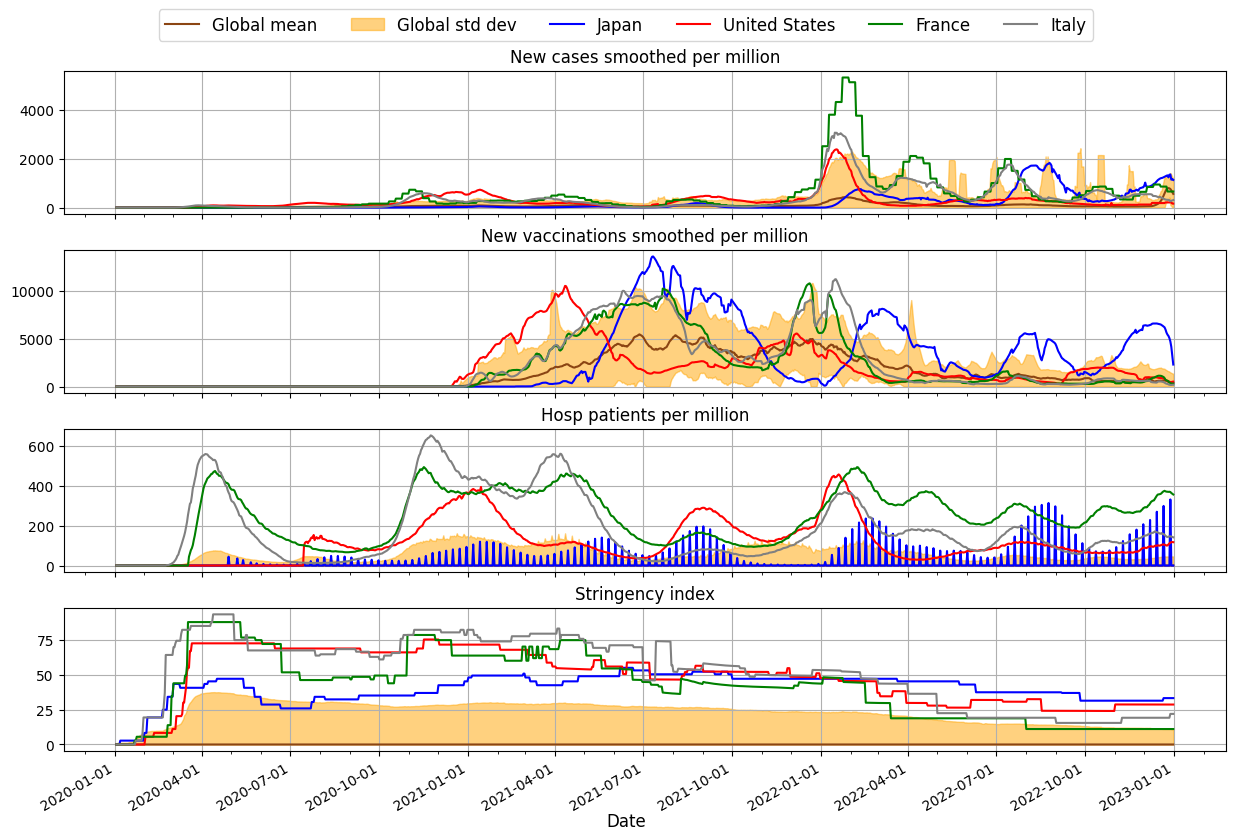

In [7]:
# re-juggle the data for a multi country chart

# the countries being analyzed
chart_labels['y_isos'] = ["JPN", "USA", "FRA", "ITA"]

plot_data = collate_plot_data(chart_labels['y_isos'], country_date_data)

# assemble the locations list
chart_labels['y_axis_labels'] = []
for iso in chart_labels['y_isos']:
    chart_labels['y_axis_labels'].append(data[iso]['location'])
    
# call multi_plots
multi_plots(chart_labels, plot_data)